In [7]:
from visTools_v2.core_functions.feature_matcher import FeatureMatcher,load_img
from visTools_v2.core_functions.operations.plotter import Plotter,Homog
import matplotlib.pyplot as plt

import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estimating the fundamental Matrix
8 points algorithm

7 points algorithm (work in progress)

Robust estimation (work in progress)


## 8-points Algorithm:

In [2]:
def FundamentalM(pairs,min_pts,norm=True):

    Hnorm = HartleysNorm(pairs)
    
    pairs = Hnorm.norm_pairs
    
    idx = np.arange(pairs[0].shape[0])
    
    idx1 = np.random.choice(idx,min_pts)

    x1 = pairs[0][idx1,0]
    y1 = pairs[0][idx1,1]

    x2 = pairs[1][idx1,0]
    y2 = pairs[1][idx1,1]

    A = np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape)))

    U,S,V = np.linalg.svd(A.T,full_matrices=False)

    F_ = V[-1].reshape((3,3))

    U,S,V = np.linalg.svd(F_,full_matrices=False)
    
    S[-1]=0
    
    F = (U.dot(np.diag(S))).dot(V)
       
    F = Hnorm.denormalize(F)
    
    pairs = Hnorm.pairs
    
    e = F_geomError(pairs,F)
      
    return F,e,pairs[0][idx1,:],pairs[1][idx1,:]

# 7-points Algorithm

In [11]:
from scipy import optimize
class mindetF:
    def __init__(self,F1,F2):
        self.F1=F1
        self.F2=F2
    def get_F(self,alpha):
        return alpha*self.F1+(1-alpha)*self.F2
        
    def get_det(self,alpha):
        return np.abs(np.linalg.det(self.get_F(alpha)))
    
    def solve(self):
        minimum = optimize.fmin(self.get_det, 0.9,full_output=False,disp=False)
        #if minimum[0]>=1e-5:print('F7 min greater than 1e-5')
        return self.get_F(minimum[0])

In [12]:
import numpy as np
F1 = np.random.randn(9).reshape((3,3))
F2 = np.random.randn(9).reshape((3,3))

In [13]:
m = mindetF(F1,F2)
m.solve()

array([[-0.05241296, -0.25736028,  0.26449319],
       [ 0.73209848, -0.2696008 ,  1.4108119 ],
       [ 0.12431728,  0.47454011, -0.44798765]])

In [4]:
from scipy import optimize

def FundamentalM7pts(pairs,min_pts,norm=True):

    Hnorm = HartleysNorm(pairs)
    
    pairs = Hnorm.norm_pairs
    
    idx = np.arange(pairs[0].shape[0])
    idx1 = np.random.choice(idx,min_pts)

    x1 = pairs[0][idx1,0]
    y1 = pairs[0][idx1,1]

    x2 = pairs[1][idx1,0]
    y2 = pairs[1][idx1,1]


    A = np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape)))

    U,S,V = np.linalg.svd(A.T)

    F1 = V[-1].reshape((3,3))
    
    F2 = V[-2].reshape((3,3))
    
    f = mindetF(F1,F2)
    
    F = Hnorm.denormalize(F)
    
    pairs = Hnorm.pairs
    
    e = F_geomError(pairs,F)
      

    return F,e,pairs[0][idx1,:],pairs[1][idx1,:]

# Hartley's normalization

In [5]:
class HartleysNorm:
    def __init__(self,pairs):
        self.pairs=pairs
        self.Tl = self.get_T(hmg(pairs[0][:,:2]))
        self.Tr = self.get_T(hmg(pairs[1][:,:2]))
        self.norm_pairs = hmg(pairs[0][:,:2]).dot(self.Tl),hmg(pairs[1][:,:2]).dot(self.Tr)
        
    def denormalize(self,F):
        return ((self.Tl.T).dot(F)).dot(self.Tr)
    
    def get_T(self,data):
        ml = data

        n = data.shape[0]

        ml_ = np.mean(ml,axis=0)

        sl = np.sqrt(np.sum((ml - ml_)**2)/(2*n))

        return np.array([[1/sl,0,(-1/sl)*ml_[0]],[0,1/sl,(-1/sl)*ml_[1]],[0,0,1]])


# Robust Estimation

In [43]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''
def RANSAC2(pairs,min_pts=4,p=0.1,P=.99,th=100,type_='affine',max_it=50000):
    print("Starting RANSAC:")

    e0=1e100
    for i in range(1000):  
        w,e,x1,x2 = FundamentalM(pairs,min_pts,norm=True)
        e = np.sum(e)
        if e<e0:
            best_w = w
            e0 = e
            
    print('RANSAC error: {}'.format(e0))
    F = np.reshape(best_w,(3,3))

    return F

# Helper functions

In [7]:
def hmg(x):
    n = x.shape[0]
    ones = np.ones(n)
    return np.vstack((x.T,ones)).T

In [31]:
def F_geomError(pairs,F):
      
    a = (F.dot(hmg(pairs[0]).T))  
    
    b = (F.T.dot(hmg(pairs[1]).T))
    
    num = np.sum((hmg(pairs[1]).T*(a))**2,axis=0)
    
    den = np.sum(a**2+b**2,axis=0)

    e = np.divide(num,den,out=np.zeros_like(num),where=den!=0)
    
    return e

In [24]:
def plot_left(im1,pairs,F,s):
    H,W = im1[0,0].shape
    draw_line = Plotter(im_shape=(H,W),**{'s':s}).lines
    f = Homog().cart2homog

    left = F.dot(f(pairs[1].T))

    
    plt.scatter(pairs[0][:,0],pairs[0][:,1],s=1,c='b')
    draw_line(left,**{'s':s})
    plt.imshow(im1[0,0],**{'cmap':'gray'})

def plot_right(im2,pairs,F,s):
    H,W = im2[0,0].shape
    draw_line = Plotter(im_shape=(H,W),**{'s':s}).lines
    f = Homog().cart2homog

    right = F.T.dot(f(pairs[0].T))

    
    plt.scatter(pairs[1][:,0],pairs[1][:,1],s=1,c='b')
    draw_line(right,**{'s':s})
    plt.imshow(im2[0,0],**{'cmap':'gray'})

In [10]:
def get_epipoles(F):
    U,S,V = np.linalg.svd(F)
    er = V[-1]
    
    U,S,V = np.linalg.svd(F.T)
    el = V[-1]
    
    return el,er


# Levenberg Marquardt, nlinear optimization

Cost function 11.6

Levenberg-Marquardt A.6.2p600

algorithm A5.6(p595)

$F = M[e]_x$

or

$f = Em$


Minimize $|AEm|$ sbt $|Em|=1$



E = computeE
A = computeA

e <-> Af map: $R^3 -> R^9$


In [44]:
class optimizeF:
    def __init__(self,F,pairs,idx):
        self.pairs = pairs
        self.update_param(F,idx)
        
    def update_param(self,F,idx):
        self.F = F
        self.idx = idx
        U,S,V = np.linalg.svd(F)
        self.pairsx = self.pairs[0][idx],self.pairs[1][idx]
        self.A = self.computeA(self.pairsx)       
        self.e0 = V[-1]

    def J(self,x0):
        fun = self.Af
        step = 1e-4
        delta = np.zeros(x0.shape[0])    
        grad = []
        for i in np.arange(x0.shape[0]):

            delta[i] = step
            x2 = x0 + delta
            x1 = x0 - delta
            increment2 = fun(x2)
            increment1 = fun(x1)
            grad.append((increment2-increment1)/(2*step))
            delta[i] -= step  

        return np.array(grad).T
    
    def computeA(self,pairs):
        x1 = pairs[0][:,0]
        y1 = pairs[0][:,1]

        x2 = pairs[1][:,0]
        y2 = pairs[1][:,1]


        return np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape))).T

    
    def computeE(self,el):
        zeros = np.zeros((3,3))
        e = np.array([[0,-el[2],el[1]],[el[2],0,-el[0]],[-el[1],el[0],0]])
        e1 = np.hstack([e,zeros,zeros])
        e2 = np.hstack([zeros,e,zeros])
        e3 = np.hstack([zeros,zeros,e])
        return np.vstack((e1,e2,e3))
    
    def Af(self,el):

        F_ = self.f_i(el)

        ei = self.A*F_[np.newaxis,:]

        return np.abs(np.sum(ei,axis=1))
       
    def f_i(self,el):
        r = 6
        E = self.computeE(el)

        U,S,V = np.linalg.svd(E)

        U_ = U[:,:r]

        _,_,V1 = np.linalg.svd(self.A.dot(U_))
        x_ = V1[-1]

        F_ = (U_.dot(x_))
        return F_
    
    def solve(self,factor=10):
        e0 = self.e0
        j = self.J(e0)
        N = j.T.dot(j)
        
        lamb = np.mean(np.diag(N))*1e-3

        ei = self.Af(e0)
        w = np.linalg.solve(N + lamb*np.diag(np.ones(3)),(-j.T).dot(ei))

        dif0 = self.Af(w) - ei
        dif0=dif0.T.dot(dif0)

        for i in range(100):

            j = self.J(e0)
            N = j.T.dot(j)
            ei = self.Af(e0)
            w = np.linalg.solve(N + lamb*np.diag(np.ones(3)),(-j.T).dot(ei))
            dif = self.Af(e0-w) - ei
            dif = dif.T.dot(dif)

            if dif<dif0:
                lamb/=factor
                dif0=dif
                e0 -= w
                
            else:
                lamb*=factor
                
    
        
        self.F = np.reshape(self.f_i(e0),(3,3)).T
        #print("Final change in Af: {}".format(dif))
        return self.F
    
    def iter_solve(self,niter=10,factor=10,th=3,diag=False):
        new_idx = self.idx
        init_inliers = np.sum(self.idx)
        best_inliers = 0
        ninliers = []
        
        for i in range(niter):

            self.update_param(self.F,new_idx)
            Fi = self.solve()

            e = F_geomError(pairs,Fi)
            new_idx = e<th
            inliers = np.sum(new_idx)
            ninliers.append(inliers)
            
            if best_inliers<inliers:
                best_F = Fi
                best_idx = new_idx
                best_inliers=inliers
            
            if diag==True:print("# inliers: {}".format(inliers))

        print("Initial n of inliers: {}".format(init_inliers))
        print("Final n of inliers: {}".format(ninliers[-1]))
        print("Best inliers: {}".format(best_inliers))
        return best_F,best_idx

# Examples/tests

## House

### Find kps (Harris + SSD)

### Automatic estimation of F
Ransac + Levenberg Marquardt

In [14]:
def adjst_coord(xk):
    y = xk1[:,0]
    x = xk1[:,1]
    return np.array((x,y)).T

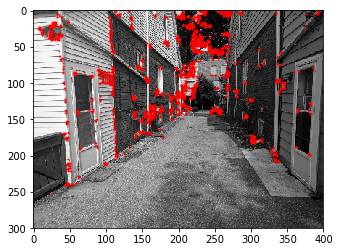

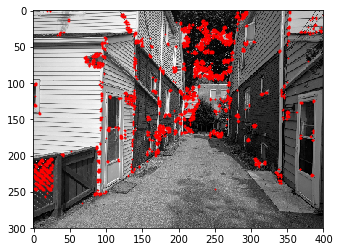

Starting RANSAC:
RANSAC error: 452.31463351251614


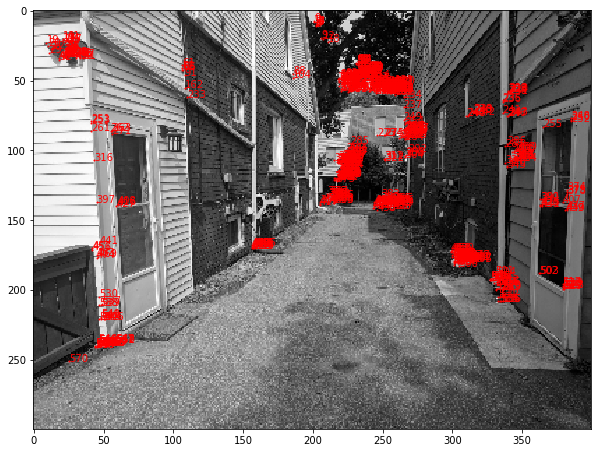

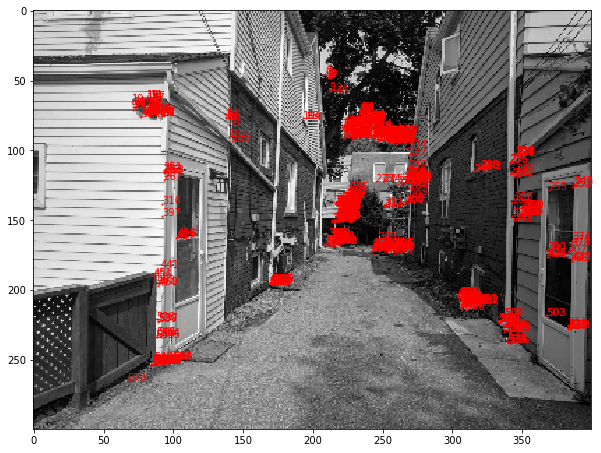

In [15]:
params={"h":55,"w":55,"th":.01}

im1 =  load_img("img/house/house5.jpg",Red=2)
im2 =  load_img("img/house/house9.jpg",Red=2)


matcher = FeatureMatcher(**params)
matcher.fit(im1,im2,match_th=.5)

xk1 = matcher.features.img1.xk[matcher.match.idx1,:]
xk2 = matcher.features.img2.xk[matcher.match.idx2,:]

pairs = (adjst_coord(xk1),adjst_coord(xk2))
F = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=100,type_='F',max_it=1000)

In [17]:
N = pairs[0][:,0].shape

In [47]:
F_ = optimizeF(F,pairs,idx=np.ones(N,dtype=bool))
Fi = F_.iter_solve(th=1)

Initial n of inliers: 571
Final n of inliers: 571
Best inliers: 571


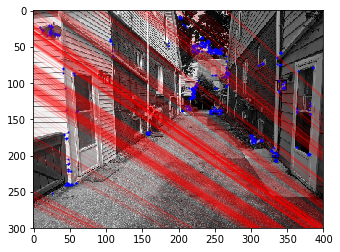

In [48]:
plot_left(im1,pairs,Fi[0],.1)

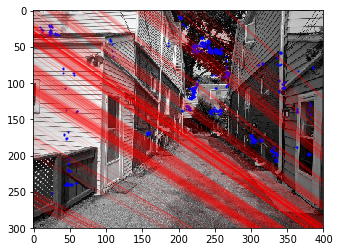

In [49]:
plot_right(im2,pairs,Fi[0],.1)

## Pepsi:

In [ ]:
params={"h":85,"w":85,"th":.001}

im1 =  load_img("img/pepsi1.jpg",Red=2)
im2 =  load_img("img/pepsi2.jpg",Red=2)


matcher = FeatureMatcher(**params)
matcher.fit(im1,im2,match_th=.5)

xk1 = matcher.features.img1.xk[matcher.match.idx1,:]
xk2 = matcher.features.img2.xk[matcher.match.idx2,:]


pairs = (adjst_coord(xk1),adjst_coord(xk2))
F = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=15,type_='F',max_it=1000)

In [ ]:
F_ = optimizeF(F,pairs)
Fi = F_.solve()

plot_left(im1,pairs,Fi)

In [ ]:
plot_left(im1,pairs,F)

In [ ]:
plot_epip_lines(im1[0,0],pairs,Fi,new_idx,'left')
plot_epip_lines(im2[0,0],pairs,Fi,new_idx,'right')

In [ ]:
F_ = optimizeF(F,pairs,idx)
Fi,new_idx = F_.iter_solve(niter=10,th=20)

plot_epip_lines(im1[0,0],pairs,Fi,new_idx,'left')
plot_epip_lines(im2[0,0],pairs,Fi,new_idx,'right')

## Uoft:

In [ ]:
params = {"h":85,"w":85,'Red':2,'th':.0001,'blur_window':(3,3),'sig':1}

im1 =  load_img("img/dino1.jpg",Red=2)
im2 =  load_img("img/dino2.jpg",Red=2)


matcher = FeatureMatcher(**params)
matcher.fit(im1,im2,match_th=.5)

xk1 = matcher.features.img1.xk[matcher.match.idx1,:]
xk2 = matcher.features.img2.xk[matcher.match.idx2,:]


pairs = (xk1,xk2)
F,idx = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=1.5,type_='F',max_it=1000)

plot_epip_lines(matcher.features.img1.im[0,0],pairs,F,idx,'left')
plot_epip_lines(matcher.features.img2.im[0,0],pairs,F,idx,'right')

In [ ]:
F_ = optimizeF(F,pairs,idx)
Fi,new_idx = F_.iter_solve(niter=10,th=1)

plot_epip_lines(matcher.features.img1.im[0,0],pairs,Fi,new_idx,'left')
plot_epip_lines(matcher.features.img2.im[0,0],pairs,Fi,new_idx,'right')

# House

In [ ]:
params = {"h":85,"w":85,'th':.03,'blur_window':(3,3),'sig':1}

im1 =  load_img("img/house/house0.jpg")
im2 =  load_img("img/house/house8.jpg")


matcher = FeatureMatcher(**params)
matcher.fit(im1,im2,match_th=.3)

xk1 = matcher.features.img1.xk[matcher.match.idx1,:]
xk2 = matcher.features.img2.xk[matcher.match.idx2,:]


pairs = (xk1,xk2)
F,idx = RANSAC2(pairs,min_pts=8,p=0.1,P=.99,th=2.5,type_='F',max_it=1000)

plot_epip_lines(matcher.features.img1.im[0,0],pairs,F,idx,'left')
plot_epip_lines(matcher.features.img2.im[0,0],pairs,F,idx,'right')

In [ ]:
F_ = optimizeF(F,pairs,idx)
Fi,new_idx = F_.iter_solve(niter=20,th=10)

plot_epip_lines(matcher.features.img1.im[0,0],pairs,Fi,new_idx,'left')
plot_epip_lines(matcher.features.img2.im[0,0],pairs,Fi,new_idx,'right')